In [1]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

#from temp_tf_load import *
sys.path.append('../../hde')
print(sys.path)
import warnings
warnings.filterwarnings('ignore')
from hde import HDE, analysis

/home/mikejones/anaconda3/bin/python
['/scratch/midway2/mikejones/srv/paper_notebooks/hde_outputs/Analysis', '/home/mikejones/anaconda3/lib/python37.zip', '/home/mikejones/anaconda3/lib/python3.7', '/home/mikejones/anaconda3/lib/python3.7/lib-dynload', '', '/home/mikejones/.local/lib/python3.7/site-packages', '/home/mikejones/anaconda3/lib/python3.7/site-packages', '/home/mikejones/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/mikejones/.ipython', '../../hde']


Using TensorFlow backend.


In [2]:
n_traj, n_frames, skip = 100, 100001, 1
traj_path = f'../../../dna_data/GC-core_321K_112-165001-190.npy'
hde_path = '../save_metatrajs/GC-core_321K_112-165001-190_200micro_3macro/hde_coords.pkl'
meta_path = '../save_metatrajs/GC-core_321K_112-165001-190_200micro_3macro/hde_meta_states.pkl'

hde_coords = pickle.load(open(hde_path, 'rb'))
meta_coords = pickle.load(open(meta_path, 'rb')).reshape(n_traj, n_frames)
traj_coords = np.load(traj_path)[:n_traj, -n_frames::skip, :100]

print(np.shape(hde_coords), traj_coords.shape, meta_coords.shape)

(100, 100001, 3) (100, 100001, 100) (100, 100001)


In [3]:
# looks for trajectories with transitions and trim those events

window, jump = 1000, 10
traj_h_list, traj_d_list, meta_list = [], [], []
for traj_h, traj_d, meta in zip(hde_coords, traj_coords, meta_coords):
    
    hybrid = traj_h[:, 0]
    if np.abs(hybrid[0] - hybrid[-1]) > 1:
        
        i = 0
        traj_len = len(hybrid)
        while i + window < traj_len:
        
            hybrid_avg = np.mean(hybrid[i:i+window])
            if np.abs(hybrid_avg) < jump/window:
                
                print('found event')
                traj_h_list.append(traj_h[i:i+window])
                traj_d_list.append(traj_d[i:i+window])
                meta_list.append(meta[i:i+window])
                print(traj_h_list[-1].shape, traj_d_list[-1].shape, meta_list[-1].shape)
                break
                
            i += jump

found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)
found event
(1000, 3) (1000, 100) (1000,)


(17, 1000)
(541,) (541,)
(429,) (429,)
(30,) (30,)


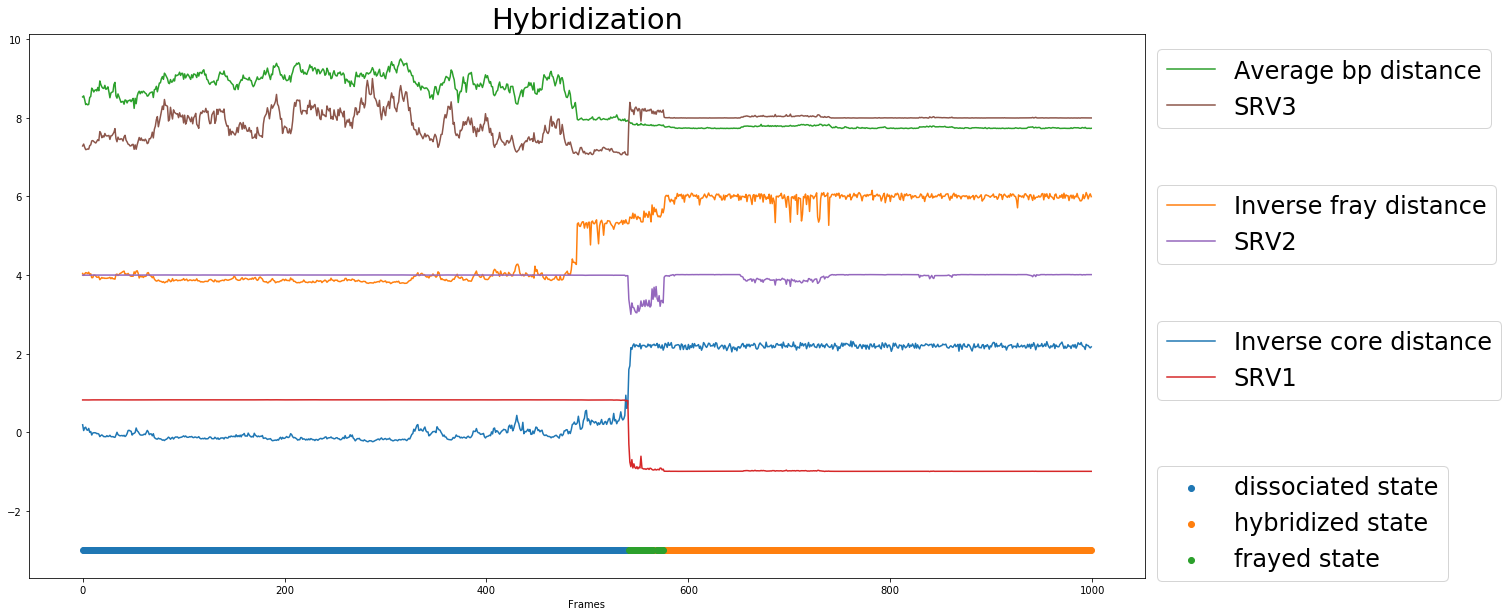

In [4]:
# maps CV indexing

'''
5'     3'
A0     9T
T1     8A
A2     7T
T3     6A
G4     5C
C5     4G
A6     3T   
T7     2A
A8     1T
T9     0A
3'     5'
'''

# select index of traj we want to look at
num_bp = 10
#plot_idx = 1
#traj_d = traj_d_list[plot_idx]
#traj_h = traj_h_list[plot_idx]

# plot each hde coord for selected traj
traj_idxs = [11] # [2, 5, 8, 11]
traj_names = ['Hybridization']   #'Dissociation'
#n_traj = 17 #len(traj_h_list)
fig, axes = plt.subplots(len(traj_idxs), 1, figsize=(20, 10*len(traj_idxs)))
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)

# collective variable list:
bp_pairs = [(i+1)*9 for i in range(num_bp)]
core_dist = [traj_d[:, 45] + traj_d[:, 54]/2 for traj_d in traj_d_list]
inner_fray_dist = [traj_d[:, 36] + traj_d[:, 63]/2 for traj_d in traj_d_list]
outer_fray_dist = [traj_d[:, 18] + traj_d[:, 81]/2 for traj_d in traj_d_list]
opp_dist = [traj_d[:, 0] + traj_d[:, 99]/2 for traj_d in traj_d_list]
avg_bp_dist = [1/np.mean([traj_d[:, i] for i in bp_pairs], axis=0) for traj_d in traj_d_list]
print(np.shape(avg_bp_dist))

loc = 'center left'
for j, idx in enumerate(traj_idxs): #range(len(traj_h_list)):
    
    ax = axes #ax = axes[j]
    traj_h = traj_h_list[idx]
    traj_d = traj_d_list[idx]
    
    ax.set_title(f'{traj_names[j]}')
    core, = ax.plot(core_dist[idx] - .5, label='Inverse core distance')
    fray, = ax.plot(inner_fray_dist[idx] + 3.5, label='Inverse fray distance')
    dist, = ax.plot(2*avg_bp_dist[idx]/max(avg_bp_dist[idx]) + 7.5, label='Average bp distance')
    ax.set_xlabel('Frames')
    
    leg_order = [core, fray, dist]
    coord_order = [core_dist[idx], inner_fray_dist[idx], 2*avg_bp_dist[idx]/max(avg_bp_dist[idx])]
    
    #core_legend = fig.legend(handles=[core], loc='lower left')
    #ax = plt.gca().add_artist(core_legend)
    #fray_legend = plt.legend(handles=[fray], loc='middle left')
    #dist_legend = plt.legend(handles=[dist], loc='upper left')
    
    # plot hde info
    line_list = []
    corr_type = pearsonr
    
    for i in range(len(traj_h[0])):
        norm = max(np.abs(traj_h[:, i]))
        coord = coord_order[i]
        corr_full = np.round( corr_type(coord, traj_h[:, 1]/norm)[0], 3)
        corr_first = np.round( corr_type(coord[:400], traj_h[:, 1][:400]/norm)[0], 3)
        corr_last = np.round( corr_type(coord[-400:], traj_h[:, 1][-400:]/norm)[0], 3)
        line, = ax.plot(traj_h[:, i]/norm + i*4, label= f'SRV{i+1}')
        #label= (f'slow mode {i+1}\n full_corr: {corr_full} pre_corr: {corr_first} post_corr: {corr_last}') ) 
        
        line_list.append(line)
    
    # plot metastable state
    n_x = len(meta_list[idx])
    scat_leg_list = []
    state_list = ['frayed', 'hybridized', 'dissociated']
    for i in reversed(range(3)):
        meta_idx = np.where(meta_list[idx]==i)[0]
        n_x = len(meta_idx)
        print(meta_idx.shape, np.full(n_x, -3).shape)
        meta_scat = ax.scatter(meta_idx, np.full(n_x, -3), label=f'{state_list[i]} state')
        scat_leg_list.append(meta_scat)
        #meta_scat = ax.scatter(meta_idx, meta_list[idx][meta_idx], c=i, label=f'state {i}')
        
    #meta_scat = ax.scatter(np.arange(n_x), np.full(n_x, -3), c=meta_list[idx], label='meta state')
    #ex_0 = ax.scatter(0, np.full(n_x, -3), c=meta_list[idx], label='meta state')
    #ax.legend(handles=[core, fray], loc='lower right')
    
    leg0 = plt.legend(handles=[leg_order[0], line_list[0]], loc=loc, bbox_to_anchor=(1,0.4))
    plt.gca().add_artist(leg0)
    leg1 = plt.legend(handles=[leg_order[1], line_list[1]], loc=loc, bbox_to_anchor=(1,0.65))
    plt.gca().add_artist(leg1)
    leg2 = plt.legend(handles=[leg_order[2], line_list[2]], loc=loc, bbox_to_anchor=(1,0.9))
    plt.gca().add_artist(leg2)
    plt.legend(handles=scat_leg_list, loc=loc, bbox_to_anchor=(1,.1))

plt.savefig(f'../../paper_figs/GC-core_tracking_{traj_names[0]}.pdf', dpi=300, bbox_inches='tight')

In [5]:
### Look for sequences with peaks in the third srv mode

# find max and min values for these coornds
skip = 10
all_srv3 = np.concatenate(hde_coords)[::skip, 2]
mode_min, mode_max = np.min(all_srv3), np.max(all_srv3)

window, jump = 10, 1
srv_min_list, srv_max_list, time_max_list  = [], [], []
traj_min_list, traj_max_list, time_min_list  = [], [], []
min_cut, max_cut = 0.8, 0.98

for idx, (srv, traj) in enumerate(zip(hde_coords, traj_coords)):
    
    srv3 = srv[::skip, 2]
    traj = traj[::skip]
    traj_len = len(srv3)
    time = np.arange(traj_len)
     
    i = 0
    while i + window < traj_len:

        if np.min(srv3[i:i+jump]) < min_cut*mode_min:

            srv_min_list.append(srv3[i:i+window//2])
            traj_min_list.append(traj[i:i+window//2])
            time_min_list.append(idx*traj_len + time[i:i+window//2]) 
            break
            
        elif np.max(srv3[i:i+window]) > max_cut*mode_max:
            
            srv_max_list.append(srv3[i-window//2:i])
            traj_max_list.append(traj[i-window//2:i])
            time_max_list.append(idx*traj_len + time[i-window//2:i]) 
            break
            
        i += jump


In [6]:
print(np.shape(traj_min_list))
print(np.shape(srv_min_list))
print(np.shape(time_min_list))

(6, 5, 100)
(6, 5)
(6, 5)


min 15002,15003,15004,15005,15006,70061,70062,70063,70064,70065,244922,244923,244924,244925,244926,398170,398171,398172,398173,398174,510209,510210,510211,510212,510213,786414,786415,786416,786417,786418
max 164372,164373,164374,164375,164376,199994,199995,199996,199997,199998,310311,310312,310313,310314,310315,427558,427559,427560,427561,427562,559156,559157,559158,559159,559160,582918,582919,582920,582921,582922,983179,983180,983181,983182,983183


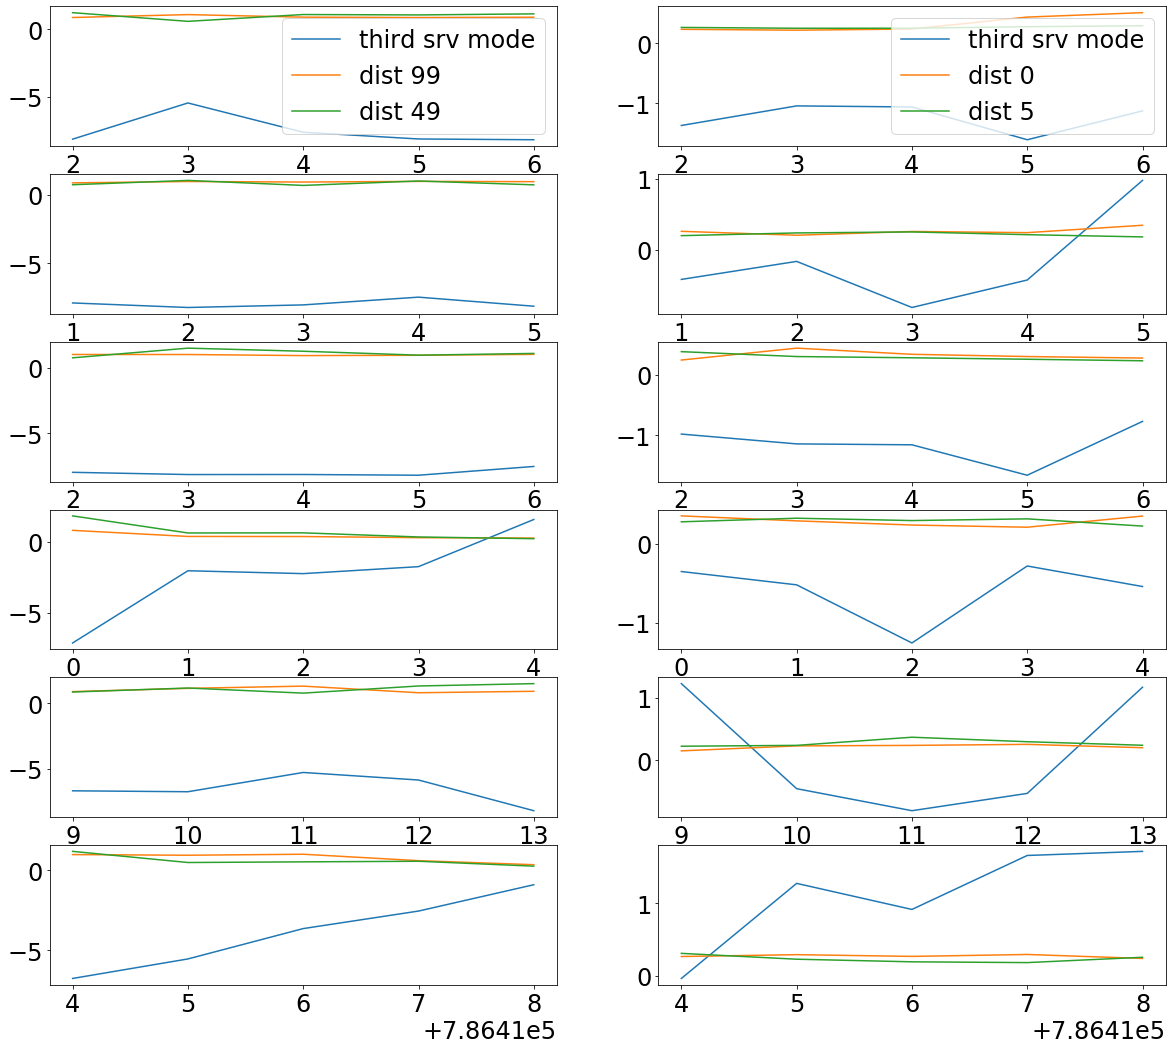

In [7]:
print('min', ','.join([str(i) for i in np.concatenate(time_min_list)]))
print('max', ','.join([str(i) for i in np.concatenate(time_max_list)]))


fig, axes = plt.subplots(len(srv_min_list), 2, figsize=(20, 3*len(srv_min_list)))

norm = 1
cv1, cv2, cv3, cv4 = 0, 99, 49, 5
for i, (srv, traj, time) in enumerate(zip(srv_min_list, traj_min_list, time_min_list)):
    ax = axes[i, 0]
    ax.plot(time, srv/norm, label='third srv mode')
    #ax.plot(traj[:, cv1], label=f'dist {cv1}')
    ax.plot(time, traj[:, cv2], label=f'dist {cv2}')
    ax.plot(time, traj[:, cv3], label=f'dist {cv3}')
    
for i, (srv, traj, time) in enumerate(zip(srv_max_list, traj_max_list, time_min_list)):
    ax = axes[i, 1]
    ax.plot(time, srv/norm, label='third srv mode')
    ax.plot(time, traj[:, cv1], label=f'dist {cv1}')
    #ax.plot(traj[:, cv2], label=f'dist {cv2}')
    ax.plot(time, traj[:, cv3], label=f'dist {cv4}')

axes[0, 0].legend()
axes[0, 1].legend()